# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/sw_ai')

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Pytorch에서 gpu를 사용하는 방법.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Utils

In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

# Custom Dataset (바꿈)

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, dataset, transform=None, infer=False):
        self.data = dataset
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# Data Loader

In [ ]:
# # Data Loader
# transform = A.Compose([A.Resize(224, 224), A.Normalize(), ToTensorV2()])
# dataset = SatelliteDataset(csv_file="./train.csv", transform=transform)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Define Model

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

# Split validation and Train (StratifiedKFold)

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
S_kfold = StratifiedKFold(n_splits=5)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Data Loader

transform = A.Compose([A.Resize(224, 224), A.Normalize(), ToTensorV2()])

data = pd.read_csv("./train.csv")
train, valid = train_test_split(data, test_size=0.2, random_state=123)

trainset = SatelliteDataset(dataset = train, transform=transform)
validset = SatelliteDataset(dataset = valid, transform=transform)

train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(validset, batch_size=16, shuffle=True, num_workers=4)

# Model Train (바꿈)

In [ ]:
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트 만든다.
list_epoch = []
list_train_loss = []
list_val_loss = []
# list_acc = []
# list_acc_epoch = []

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    # ===================== Train ===================== #
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    result = f'(train) Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}'
    list_epoch.append(epoch)
    list_train_loss.append(epoch_loss/len(train_dataloader))

    # ===================== Validation ===================== #
    model.eval()
    epoch_loss = 0
    for images, masks in tqdm(valid_dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))

        epoch_loss += loss.item()

    list_val_loss.append(epoch_loss/len(valid_dataloader))
    print(result)

100%|██████████| 90/90 [05:10<00:00,  3.45s/it]


(train) Epoch 1, Loss: 0.1741658167428329


100%|██████████| 90/90 [00:26<00:00,  3.41it/s]


(train) Epoch 2, Loss: 0.12343117035403639


100%|██████████| 90/90 [00:25<00:00,  3.48it/s]


(train) Epoch 3, Loss: 0.10940315880152691


100%|██████████| 90/90 [00:25<00:00,  3.47it/s]


(train) Epoch 4, Loss: 0.10084085800901514


100%|██████████| 90/90 [00:25<00:00,  3.51it/s]


(train) Epoch 5, Loss: 0.10193259714573037


100%|██████████| 90/90 [00:24<00:00,  3.60it/s]


(train) Epoch 6, Loss: 0.09306290605906345


100%|██████████| 90/90 [00:25<00:00,  3.47it/s]


(train) Epoch 7, Loss: 0.09010101051307191


100%|██████████| 90/90 [00:26<00:00,  3.42it/s]


(train) Epoch 8, Loss: 0.0868071882309867


100%|██████████| 90/90 [00:26<00:00,  3.37it/s]


(train) Epoch 9, Loss: 0.08499295218568556


100%|██████████| 90/90 [00:26<00:00,  3.39it/s]

(train) Epoch 10, Loss: 0.0832017283124917


# Report Experiment (NEW)

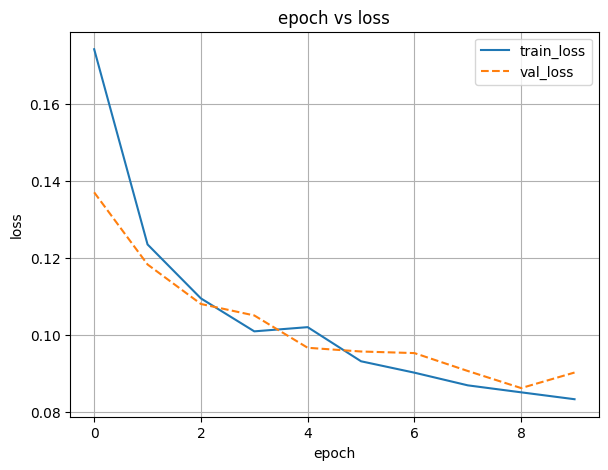

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')


plt.show()

epoch 60번 에 따른 loss

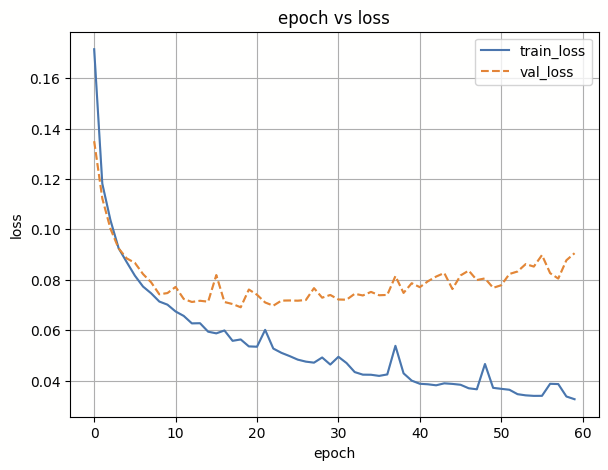

In [ ]:
np.argmin(list_val_loss)

17


# Inference



In [ ]:
test_data = pd.read_csv("./test.csv")

In [ ]:
test_dataset = SatelliteDataset(dataset = test_data, transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [2:24:45<00:00,  2.29s/it]


# Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./submit_lee.csv', index=False)

# Dice Coefficient(Score) 성능 평가

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 1]
    gt_mask_rle = ground_truth_df.iloc[:, 1]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)